## Importing CNN libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

## Preparing the dataset

In [5]:


import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

# Dataset paths
datasetDirectory = 'asl_alphabet_train/asl_alphabet_train'

# Output directories for split dataset
splittedDatasetDirectory = 'data'
trainingDatasetDir = os.path.join(splittedDatasetDirectory, 'train')
validationDatasetDir = os.path.join(splittedDatasetDirectory, 'val')
testingDatasetDir = os.path.join(splittedDatasetDirectory, 'test')

# Create directories for train, validation, and test splits
for dir_path in [trainingDatasetDir, validationDatasetDir, testingDatasetDir]:
    for className in [d for d in os.listdir(datasetDirectory) if os.path.isdir(os.path.join(datasetDirectory, d)) and not d.startswith('.')]:
        os.makedirs(os.path.join(dir_path, className), exist_ok=True)

# Split the data
for className in [d for d in os.listdir(datasetDirectory) if os.path.isdir(os.path.join(datasetDirectory, d)) and not d.startswith('.')]:
    classDir = os.path.join(datasetDirectory, className)
    images = [f for f in os.listdir(classDir) if os.path.isfile(os.path.join(classDir, f))]
    
    trainingImages, tempImages = train_test_split(images, test_size=0.3, random_state=42)
    validationImages, testingImages = train_test_split(tempImages, test_size=0.5, random_state=42)
    
    # Move images to respective directories
    for image in trainingImages:
        shutil.copy(os.path.join(classDir, image), os.path.join(trainingDatasetDir, className, image))
    for image in validationImages:
        shutil.copy(os.path.join(classDir, image), os.path.join(validationDatasetDir, className, image))
    for image in testingImages:
        shutil.copy(os.path.join(classDir, image), os.path.join(testingDatasetDir, className, image))

# Helper function to delete .DS_Store files
def deleteDSStore(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file == '.DS_Store':
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Deleted: {file_path}")

# Clean hidden files
deleteDSStore(datasetDirectory)
deleteDSStore(splittedDatasetDirectory)

# Set up ImageDataGenerators
trainingDataGenerator = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

validationDataGenerator = ImageDataGenerator(rescale=1.0 / 255)
testingDataGenerator = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators
trainGenerator = trainingDataGenerator.flow_from_directory(
    trainingDatasetDir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
)

validationGenerator = validationDataGenerator.flow_from_directory(
    validationDatasetDir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
)

testGenerator = testingDataGenerator.flow_from_directory(
    testingDatasetDir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
)

Found 58800 images belonging to 28 classes.
Found 12600 images belonging to 28 classes.
Found 12600 images belonging to 28 classes.


### checking on the dataset

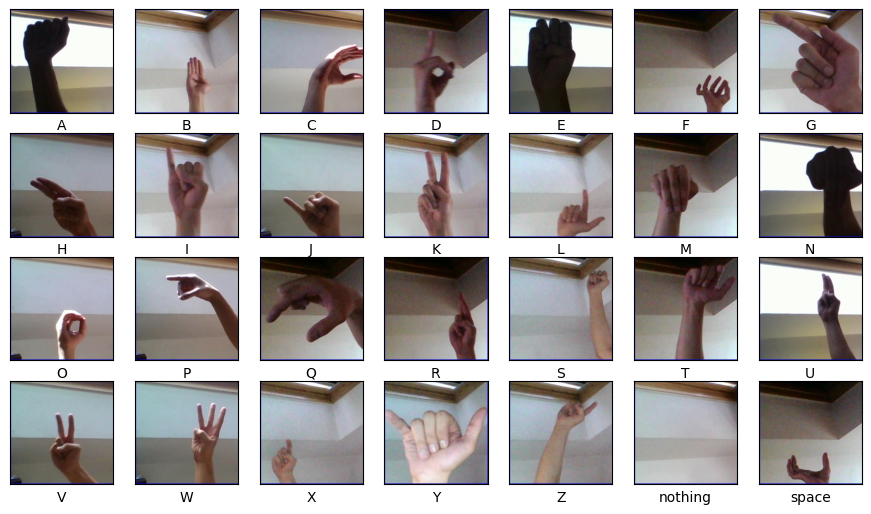

In [ ]:

classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
            'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V',
            'W', 'X', 'Y', 'Z', 'nothing', 'space']
            # optionally you can add del if you have del class in you dataset directory


plt.figure(figsize=(11, 11))
for i in range (0,28):
    plt.subplot(7,7,i+1)
    plt.xticks([])
    plt.yticks([])
    path =  f"{datasetDirectory}/{classes[i]}/{classes[i]}{random.randint(1, 3000)}.jpg"
    img = plt.imread(path)
    plt.imshow(img)
    plt.xlabel(classes[i])

## Building CNN Model 

In [30]:

numClasses = len(trainGenerator.class_indices)

cnnASLModel = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2), padding='same'),
    Dropout(0.3),
    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(numClasses, activation='softmax'),
])

cnnASLModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/Users/givoraed/Documents/Term 9/ASL_Project/AIvenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## diffrent optimizers

In [31]:
# cnnModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

############# 1st optimizer is Adam ###################

#optimizer=Adam(learning_rate=0.001)

############# 2nd optimizer is RMSprop ###################


# optimizer = RMSprop(
#     learning_rate=0.001,  # Set the learning rate (you might need to tune this)
#     rho=0.9,  # Decay rate for the moving average of squared gradients
#     epsilon=1e-07,  # Small value to avoid division by zero
#     # ... other parameters if needed ...
# )

############# 3rd optimizer is RMSprop ###################

# optimizer = SGD(
#     learning_rate=0.01,  # Set the learning rate
#     momentum=0.9,  # Momentum value (typically between 0.5 and 0.9)
#     # ... other parameters if needed ...
# )

##############################################################

# sparse_categorical_crossent not used because we are using one hot encoding

##############################################################


## Checkpoints

In [32]:
# Define the checkpoint callback
checkpointFilePath = 'cnnASLModel.keras'
checkpointCallback = ModelCheckpoint(
    filepath=checkpointFilePath,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Save only the best model
    save_weights_only=False, # Save the entire model
    mode='max',              # Maximize the monitored value
    verbose=1                # Verbosity level
)

## Training Model

In [33]:
# Calculate steps per epoch and validation steps
stepsPerEpoch = (trainGenerator.samples // trainGenerator.batch_size) + 1
validationSteps = (validationGenerator.samples // validationGenerator.batch_size) + 1

# Train the model
history = cnnASLModel.fit(
    trainGenerator,
    steps_per_epoch=stepsPerEpoch,
    epochs=10,
    validation_data=validationGenerator,
    validation_steps=validationSteps,
    callbacks=[checkpointCallback],
)


Epoch 1/10


/Users/givoraed/Documents/Term 9/ASL_Project/AIvenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1837/1838 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1410 - loss: 3.0520
Epoch 1: val_accuracy improved from -inf to 0.41857, saving model to cnnASLModel.keras
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 100s 54ms/step - accuracy: 0.1411 - loss: 3.0515 - val_accuracy: 0.4186 - val_loss: 1.6857
Epoch 2/10
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4209 - loss: 1.7413
Epoch 2: val_accuracy improved from 0.41857 to 0.62056, saving model to cnnASLModel.keras
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 104s 57ms/step - accuracy: 0.4209 - loss: 1.7412 - val_accuracy: 0.6206 - val_loss: 1.0219
Epoch 3/10
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5494 - loss: 1.2982
Epoch 3: val_accuracy did not improve from 0.62056
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 102s 55ms/step - accuracy: 0.5494 - loss: 1.2982 - val_accuracy: 0.5926 - val_loss: 1.1776
Epoch 4/10
1838/1838 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6226 - loss: 1.0859
Epoch 4: val_accuracy improved from 0.62056 to 0.83913, savin

## Save the model

In [3]:
# cnnASLModel.save('cnnASLModel.keras')

from tensorflow.keras.models import load_model
loadedModel = load_model('cnnASLModel.keras')

# Example: Evaluate the loaded model on the test dataset
testLoss, testAccuracy = loadedModel.evaluate(testGenerator)

/Users/givoraed/Documents/Term 9/ASL_Project/AIvenv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9554 - loss: 0.1399


## training & validation graph

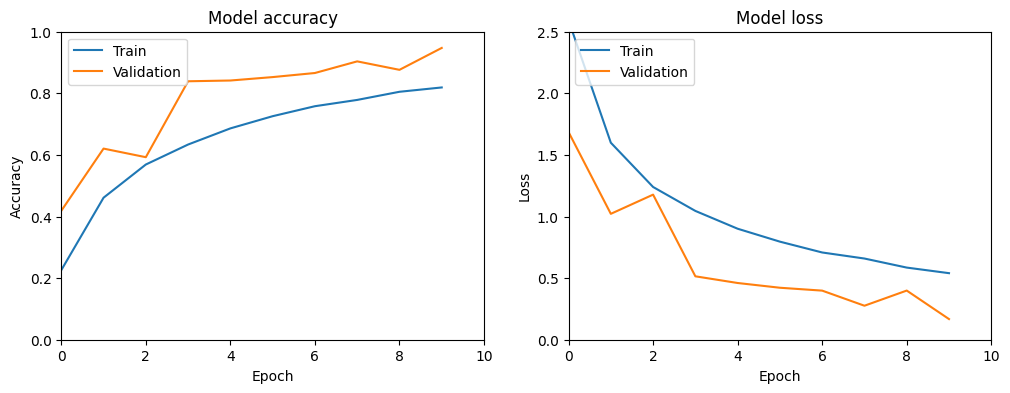

In [40]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4)) 

plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 10)
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2) # 1 row, 2 columns, plot 2
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 2.5)
plt.xlim(0, 10)
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Predctions

In [5]:
import numpy as np

# yPredictions = cnnASLModel.predict(testGenerator, steps=testGenerator.samples // testGenerator.batch_size + 1)
yPredictions = loadedModel.predict(testGenerator, steps=testGenerator.samples // testGenerator.batch_size + 1)
yPredictedClasss = np.argmax(yPredictions, axis=1)  # Convert predictions to class indices



394/394 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


## Confusion matrix

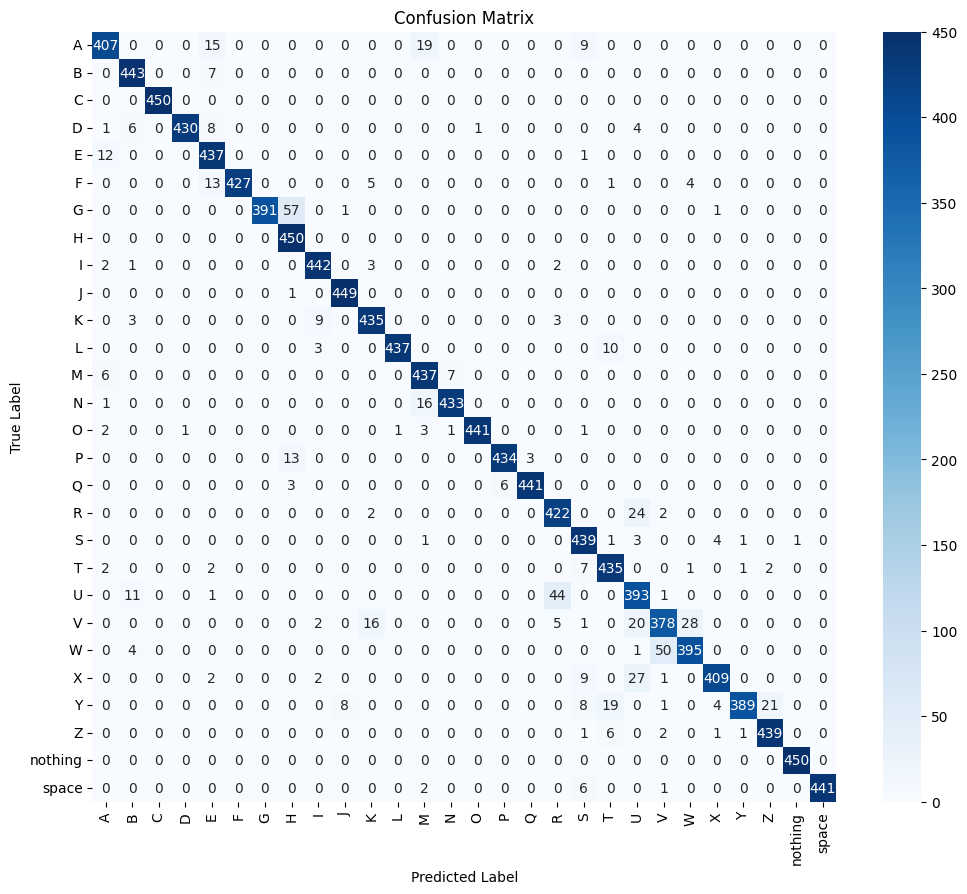

In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

yTrueValues = testGenerator.classes  # True class labels from the generator
classLabels = list(testGenerator.class_indices.keys())  # Class labels

# Compute confusion matrix
cm = confusion_matrix(yTrueValues, yPredictedClasss)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classLabels, yticklabels=classLabels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Classification report

In [7]:
import pandas as pd

# Classification report as a DataFrame
report = classification_report(yTrueValues, yPredictedClasss, target_names=classLabels, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Display classification report as a table
print("Classification Report (Complete Table):\n")
print(df_report)

# save the report to a CSV file
df_report.to_csv('CNNClasificationReport.csv', index=True)

Classification Report (Complete Table):

              precision    recall  f1-score       support
A              0.939954  0.904444  0.921857    450.000000
B              0.946581  0.984444  0.965142    450.000000
C              1.000000  1.000000  1.000000    450.000000
D              0.997680  0.955556  0.976163    450.000000
E              0.901031  0.971111  0.934759    450.000000
F              1.000000  0.948889  0.973774    450.000000
G              1.000000  0.868889  0.929845    450.000000
H              0.858779  1.000000  0.924025    450.000000
I              0.965066  0.982222  0.973568    450.000000
J              0.980349  0.997778  0.988987    450.000000
K              0.943601  0.966667  0.954995    450.000000
L              0.997717  0.971111  0.984234    450.000000
M              0.914226  0.971111  0.941810    450.000000
N              0.981859  0.962222  0.971942    450.000000
O              0.997738  0.980000  0.988789    450.000000
P              0.986364  0.9644